In [1]:
import cv2                              # for working with images
from matplotlib import pyplot as plt    # for plotting images
import numpy as np                      # for matrix
import imutils                          # for grabbing contours
import easyocr                          # for detecting the characters from license plate
from os import path                     # for saving results

About the dataset we are using [Car License Plate Detection](https://www.kaggle.com/andrewmvd/car-plate-detection) dataset from Kaggle. It has 433 images of differnt types of complexity.

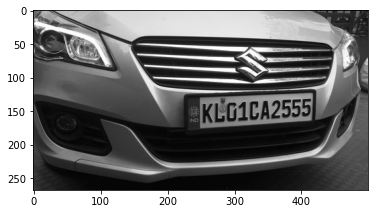

In [2]:
img = cv2.imread('images/Cars0.png') # load the image
gsimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converted image to grayscale for faster processing
plt.imshow(cv2.cvtColor(gsimg, cv2.COLOR_BGR2RGB)) # plot image

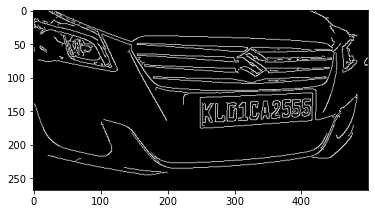

In [3]:
bfilter = cv2.bilateralFilter(gsimg, 15, 75, 75) # Noise reduction
edged = cv2.Canny(bfilter, 30, 200) # Edge detection

plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [4]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # finds the contours and only consider the corners
contours = imutils.grab_contours(keypoints) # grabs the contours from points
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] # store the sorted top 10 contours by area and remove rest

In [5]:
location = None
for contour in contours: 
    sides = cv2.approxPolyDP(contour, 10, True) # finding the no. of edges of the contours with 10% epsilon i.e 10% of arc length
    if len(sides) == 4:  # rectangle has 4 edges so the largest rectangle in the picture is our plate, running the loop till we find that
        location = sides  # storing the location of largest rectangle and breaking the loop
        break
    
print(location)

[[[417 124]]

 [[249 130]]

 [[249 175]]

 [[415 164]]]


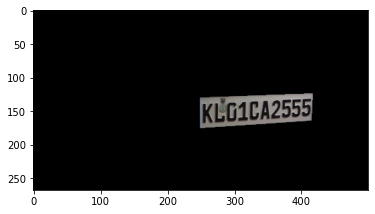

In [6]:
mask = np.zeros(gsimg.shape, np.uint8) # This creates a blank mask of same shape as of the original image
new_image = cv2.drawContours(mask, [location], 0,255, -1) # Drawn our contour out within the image
new_image = cv2.bitwise_and(img, img, mask=mask) # Then we have layed the mask on top of the original image
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

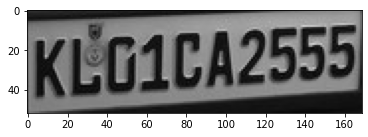

In [7]:
(x, y) = np.where(mask==255) # finding the coordinates of numberplate
(x1, y1) = (np.min(x), np.min(y)) # grab the top left corner
(x2, y2) = (np.max(x), np.max(y)) # grab the bottom right corner
cropped_image = gsimg[x1: x2+1, y1: y2+1] # Crop the image based on the corners
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))

In [8]:
reader = easyocr.Reader(['en'], gpu = False) # Create the OCR model with english language and running it without gpu
result = reader.readtext(cropped_image) # Identify characters from cropped image

result

Using CPU. Note: This module is much faster with a GPU.


[([[0, 0], [169, 0], [169, 52], [0, 52]], 'KLO1CA2555', 0.523779965784833)]

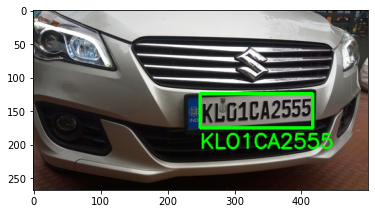

In [9]:
text = result[0][-2] # Grabbed specified text
font = cv2.FONT_HERSHEY_SIMPLEX # Specifid text font 
res = cv2.putText(img, text=text, org=(y1,x2+30), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(sides[0][0]), tuple(sides[2][0]), (0,255,0),3) # This and last line specifies location of text and rectangle on image 
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))